In [60]:
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt
from mnist import MNIST
from utils import show_image
from sklearn import metrics

In [2]:
mnist = MNIST('datasets/mnist')
train_images, train_labels = mnist.load_training()
test_images, test_labels = mnist.load_testing()

shape = (28,28)

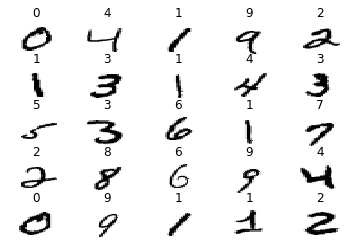

In [3]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,26):
    ax = fig.add_subplot(5, 5, i)
    ax.set_title(train_labels[i])
    show_image(train_images[i],shape, ax=ax)

## Build a NN

Rede Neural Densa

### 1 - Pesos que serão treinados

In [4]:
input_size = shape[0]*shape[1]

l1_size = 100
l2_size = 50

output_size = 10

w = {
    'w1':tf.Variable(tf.random_normal([input_size, l1_size])),
    'w2':tf.Variable(tf.random_normal([l1_size, l2_size])),
    'w3':tf.Variable(tf.random_normal([l2_size, output_size]))
}

b = {
    'b1': tf.Variable(tf.random_normal([l1_size])),
    'b2': tf.Variable(tf.random_normal([l2_size])),
    'b3': tf.Variable(tf.random_normal([output_size])),
}

In [5]:
def nn(x_value):
    
    h1 = tf.add(tf.matmul(x_value,w['w1']),b['b1'])
    h2 = tf.add(tf.matmul(h1,w['w2']),b['b2'])
    out = tf.add(tf.matmul(h2,w['w3']),b['b3'])
    
    return out

## Teste com um valor

In [44]:
init_op = tf.global_variables_initializer()

x_v = np.matrix(train_images[:2], dtype=np.float32)
with tf.Session() as sess:
    sess.run(init_op)
    out = nn(x_v)
    print(sess.run(nn(x_v)))

[[  54800.24    177347.31   -413128.4    -183189.17    173028.95
     4612.4683  -33792.074   145859.08   -351575.03   -209143.61  ]
 [  70283.4     266426.78   -173190.3    -247247.45    135290.67
    19418.867   103310.805    24037.963  -240535.83   -199700.05  ]]


## 2 - LossFunction

In [6]:
labels_prepared = np.zeros((len(train_labels),10),dtype=np.float32)
for i in range(len(train_labels)):
        labels_prepared[i,train_labels[i]] = 1.0

In [7]:
def loss(outs,inicio,fim):
    return tf.losses.mean_squared_error(labels_prepared[inicio:fim],outs)

# 3 - Minimizando o erro

In [18]:
adam = tf.train.AdamOptimizer(learning_rate=0.1)

In [19]:
def get_batch_range(batch_i,batch_size,total_size):
    i = batch_size*batch_i
    f = i + batch_size
    if f > total_size:
        f = total_size
    return i,f

In [22]:
init_op = tf.global_variables_initializer()

In [62]:
n_batchs = 20

total_size = len(train_labels)
batch_size = int(total_size/n_batchs)

loss_vector = []

input_x = tf.placeholder(dtype=tf.float32,shape=(batch_size,input_size), name='input_x')
input_x_test = tf.placeholder(dtype=tf.float32,shape=(len(test_labels),input_size), name='input_x_test')

with tf.Session() as sess:

    sess.run(init_op)
    out = nn(input_x)
    for i in range(10):
        print("="*10 +" EPOCH "+str(i)+" "+"="*10)
        for j in range(n_batchs):
            inicio,fim = get_batch_range(j, batch_size, total_size)   
            l_tensor = loss(nn(input_x),inicio, fim)
            a = adam.minimize(l_tensor, var_list=[w['w1'],w['w2'],w['w3'],b['b1'],b['b2'],b['b3']])

            sess.run(a, feed_dict={input_x:train_images[inicio:fim]})
            l = sess.run(l_tensor, feed_dict={input_x:train_images[inicio:fim]})
            loss_vector.append(l)

            if j%5 == 0:
                print(l)

        result_nn = sess.run(nn(input_x_test), feed_dict={input_x_test:test_images})
        result_test = []
        for r in result_nn:
            result_test.append(np.argmax(r))
        print(metrics.classification_report(test_labels.tolist(),result_test))
        print("="*27)

========== EPOCH 0 ==========
263833630000.0
13215429000.0
14129381000.0
8942671000.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.14      0.00      0.01      1135
           2       0.12      0.34      0.18      1032
           3       0.07      0.04      0.05      1010
           4       0.11      0.11      0.11       982
           5       0.10      0.39      0.16       892
           6       0.04      0.02      0.03       958
           7       0.03      0.00      0.00      1028
           8       0.09      0.12      0.11       974
           9       0.06      0.01      0.01      1009

   micro avg       0.10      0.10      0.10     10000
   macro avg       0.08      0.10      0.06     10000
weighted avg       0.08      0.10      0.06     10000

========== EPOCH 1 ==========
3291559200.0
1634637200.0
1723057500.0
843555900.0
              precision    recall  f1-score   support

           0       

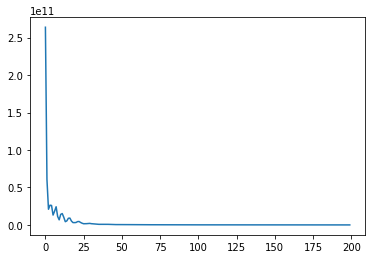

In [63]:
%matplotlib inline
plt.plot(loss_vector)